### Importing Utility Packages

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import tarfile, os
import numpy as np
import shutil

from google.colab import drive
drive.mount('/content/drive')

### Downloading Training Data to the Server

In [ ]:
!cp /content/drive/MyDrive/datasets-projeto/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

!cp -r /content/drive/MyDrive/datasets-projeto/nih-files /content

extract_files = os.listdir('/content/nih-files')

for files in extract_files:
  print(f'Extraindo /content/nih-files/{files}')
  file_ = tarfile.open(f'/content/nih-files/{files}')
  file_.extractall('/content/')
  file_.close()
  os.remove(f'/content/nih-files/{files}')

!rm -r /content/nih-files

!cp /content/drive/MyDrive/datasets-projeto/vinbigdata-dataset.zip /content/
!unzip /content/vinbigdata-dataset.zip
!rm /content/vinbigdata-dataset.zip

### Organizing and Analyzing Data

In [2]:
dataset = pd.read_csv('/content/all_datasets.csv', index_col = 0)
dataset = dataset[((dataset['Opacity'] == 1.0) | 
                   (dataset['Atelectasis'] == 1.0) | 
                   (dataset['Pneumothorax'] == 1.0) | 
                   (dataset['Effusion'] == 1.0)) & 
                  (dataset['Nodule/Mass'] == 0.0) &
                  (dataset['No Finding'] == 0.0)].copy()

dataset.drop(labels = 'Nodule/Mass', axis = 1, inplace = True)
dataset.drop(labels = 'No Finding', axis = 1, inplace = True)
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

Text(0, 0.5, 'Imagens')

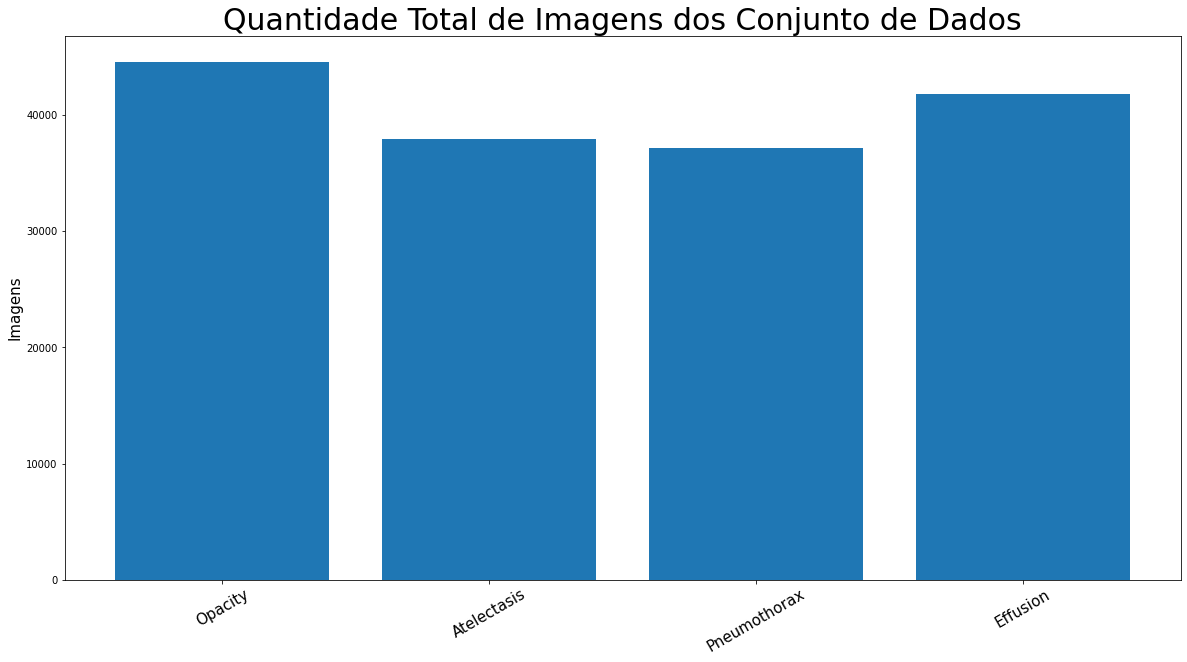

In [3]:
count_findings = list()
for finding in list(dataset.columns)[4:]:
  count = dict(dataset[finding].value_counts())[1.0]
  count_findings.append(count)

plt.figure(figsize = (20, 10))
plt.bar(list(dataset.columns)[4:], count_findings)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

In [4]:
opacity = np.array(dataset['Opacity']).astype(str)
atelectasis = np.array(dataset['Atelectasis']).astype(str)
pneumothorax = np.array(dataset['Pneumothorax']).astype(str)
effusion = np.array(dataset['Effusion']).astype(str)

all_labels = np.zeros(effusion.shape).astype(str)
for index in range(0, len(opacity)):
  all_labels[index] = opacity[index] + atelectasis[index] + pneumothorax[index]
  all_labels[index] += effusion[index]

dataset['labels_ref'] = all_labels

In [5]:
f_train, f_val = train_test_split(dataset, test_size = 0.2, random_state = 42, 
                                  stratify = dataset['labels_ref'])
f_val, f_test = train_test_split(f_val, test_size = 0.5, random_state = 42, 
                                  stratify = f_val['labels_ref'])

f_train.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_val.drop(labels = ['labels_ref'], axis = 1, inplace = True)
f_test.drop(labels = ['labels_ref'], axis = 1, inplace = True)

Text(0, 0.5, 'Imagens')

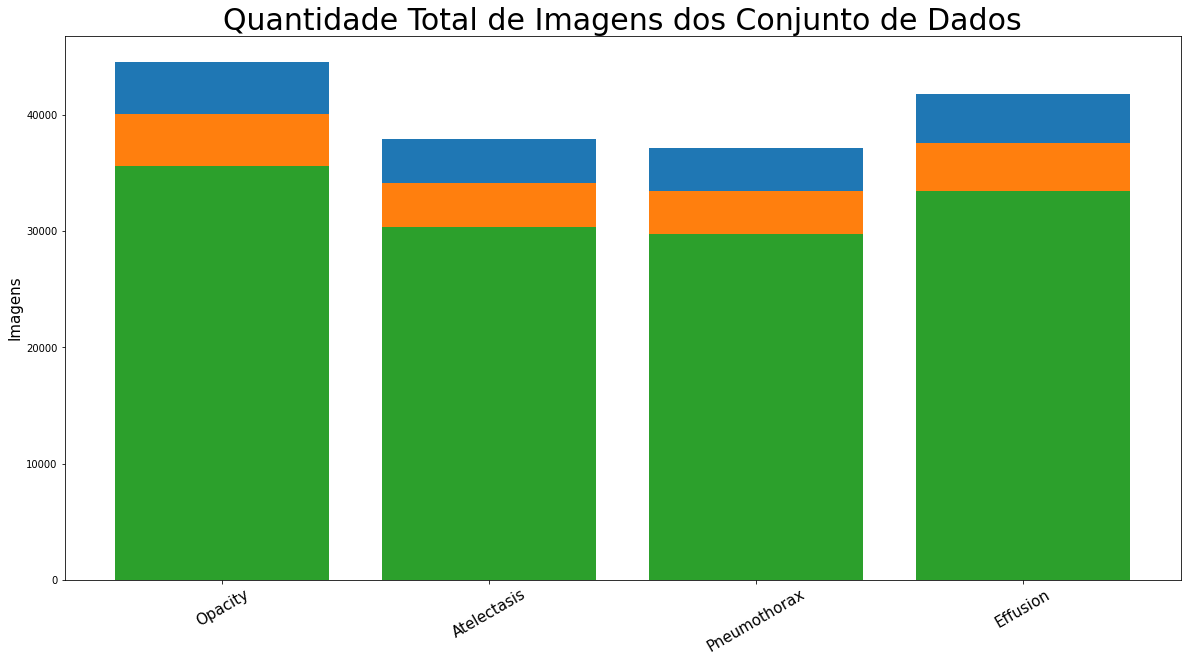

In [6]:
count_train, count_val, count_test = [], [], []
for finding in list(f_train.columns)[4:]:
  c_train = dict(f_train[finding].value_counts())[1.0]
  c_val = dict(f_val[finding].value_counts())[1.0]
  c_test = dict(f_test[finding].value_counts())[1.0]
  count_train.append(c_train), count_val.append(c_val), count_test.append(c_test)

plt.figure(figsize = (20, 10))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val, count_test), 
                                          axis = 0))
plt.bar(list(f_train.columns)[4:], np.sum((count_train, count_val), axis = 0))
plt.bar(list(f_train.columns)[4:], count_train)
plt.xticks(rotation = 30, size = 15)
plt.title('Quantidade Total de Imagens dos Conjunto de Dados', size = 30)
plt.ylabel('Imagens', size = 15)

### Keras Data Generator

In [7]:
image_size, batch_size = 256, 64
labels = ['Opacity', 'Atelectasis', 'Pneumothorax', 'Effusion']

In [8]:
core_idg = ImageDataGenerator(rescale = 1/255., 
                              shear_range = 0.1, zoom_range = 0.15,
                              rotation_range = 5, width_shift_range = 0.1, 
                              height_shift_range = 0.05, fill_mode = 'constant')

train_gen = core_idg.flow_from_dataframe(dataframe = f_train, directory = None, 
                                         x_col = 'Path', y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size))

core_idg = ImageDataGenerator(rescale = 1/255.)

valid_gen = core_idg.flow_from_dataframe(dataframe = f_val, directory = None, 
                                         x_col = 'Path',  y_col = labels, 
                                         class_mode = 'raw', 
                                         batch_size = batch_size,
                                         target_size = (image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe = f_test, 
                                                   directory = None, 
                                                   x_col = 'Path',
                                                   y_col = labels, 
                                                   class_mode = 'raw', 
                                                   batch_size = 2912,
                                                   target_size = (image_size, 
                                                                  image_size)))

Found 70159 validated image filenames.
Found 8770 validated image filenames.
Found 8770 validated image filenames.


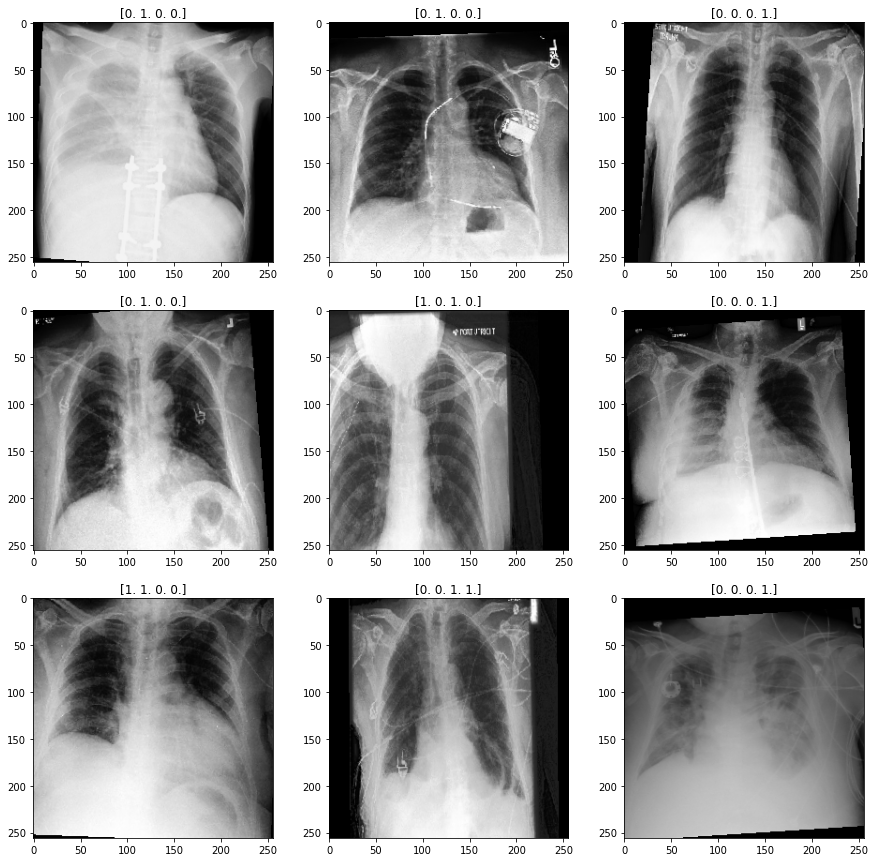

In [9]:
(x,y) = train_gen[0]
fig, axs = plt.subplots(3, 3, figsize = (15, 15))
count = 0
for i in range(0,3):
  for j in range(0,3):
    axs[i,j].set_title(str(y[count]))
    axs[i,j].imshow(x[count])
    count +=1

### Organizing a Callback Utility Function

In [10]:
def get_callbacks(model_name, csv_filename, monitor = 'val_acc',):
    '''
    creates a list of useful callbacks for training the network

    Args:
        model_name (str) --> model name under review
        monitor (str) --> callback analysis metrics
        csv_filename (str) --> log csv file name

    Returns:
        callbacks (list) --> callback list
    '''
    checkpoint_file = f'model.{model_name}.h5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_file,
                                                    verbose = 1, 
                                                    save_best_only = True, 
                                                    monitor = monitor, 
                                                    mode = 'max')
    csv_logger = tf.keras.callbacks.CSVLogger(csv_filename, separator = ",", 
                                              append = False)
    
    return [checkpoint, csv_logger]

### Defining a Layer Freezing Method

In [11]:
def freeze_layers(conv_base, layer_name):
  '''
  freeze layers of convolutional neural network training

  Args:
    conv_base (tensor) --> convolutional layers of the model
    layer_name (str) --> name of the freezing weight boundary layer
  '''

  conv_base.trainable = True
  set_trainable = False

  for layer in conv_base.layers:
    if layer.name == layer_name: set_trainable = True
    if set_trainable: layer.trainable = True
    else: layer.trainable = False
  
  return None

### Xception

In [ ]:
base_model = Xception(include_top = False, weights = 'imagenet', 
                             input_shape = (image_size, image_size, 3))
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(x)
xception = tf.keras.Model(base_model.input, output)
xception.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                 loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0), 
                metrics = [tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('xception', 'xception.csv' ,'val_auc')

In [16]:
layers_name = list()
for layer in base_model.layers:
  layers_name.append(layer.name)

block_names = ['input_1', 'block4_sepconv1_act', 'block6_sepconv3_act', 
               'block9_sepconv1_bn', 'block11_sepconv3_bn']

for blocks in block_names:
  try:
    layers_name.index(blocks)
    print('Bloco ' + blocks + ' found!')
  except ValueError:
    print('Bloco ' + blocks + ' not found!')

Bloco input_1 found!
Bloco block4_sepconv1_act found!
Bloco block6_sepconv3_act found!
Bloco block9_sepconv1_bn found!
Bloco block11_sepconv3_bn found!


In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[4])
xception.summary()

In [18]:
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5692 - auc: 0.7582
Epoch 1: val_auc improved from -inf to 0.77285, saving model to model.xception.h5
1096/1096 [==============================] - 1138s 1s/step - loss: 0.5692 - auc: 0.7582 - val_loss: 0.5647 - val_auc: 0.7728
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5290 - auc: 0.7982
Epoch 2: val_auc improved from 0.77285 to 0.77703, saving model to model.xception.h5
1096/1096 [==============================] - 1114s 1s/step - loss: 0.5290 - auc: 0.7982 - val_loss: 0.6415 - val_auc: 0.7770
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.5077 - auc: 0.8161
Epoch 3: val_auc improved from 0.77703 to 0.78758, saving model to model.xception.h5
1096/1096 [==============================] - 1114s 1s/step - loss: 0.5077 - auc: 0.8161 - val_loss: 0.5905 - val_auc: 0.7876
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4866 - auc: 0.8333
Epoch

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception1')
!zip -r model_xception1.zip /content/model_xception1
shutil.move('/content/model_xception1.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[3])
xception.summary()

In [21]:
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4611 - auc: 0.8517
Epoch 1: val_auc improved from 0.79333 to 0.81323, saving model to model.xception.h5
1096/1096 [==============================] - 1110s 1s/step - loss: 0.4611 - auc: 0.8517 - val_loss: 0.5440 - val_auc: 0.8132
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4339 - auc: 0.8701
Epoch 2: val_auc improved from 0.81323 to 0.82913, saving model to model.xception.h5
1096/1096 [==============================] - 1111s 1s/step - loss: 0.4339 - auc: 0.8701 - val_loss: 0.5509 - val_auc: 0.8291
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3995 - auc: 0.8907
Epoch 3: val_auc improved from 0.82913 to 0.83539, saving model to model.xception.h5
1096/1096 [==============================] - 1110s 1s/step - loss: 0.3995 - auc: 0.8907 - val_loss: 0.5262 - val_auc: 0.8354
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3628 - auc: 0.9103
Ep

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception2')
!zip -r model_xception2.zip /content/model_xception2
shutil.move('/content/model_xception2.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[2])
xception.summary()

In [27]:
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4648 - auc: 0.8494
Epoch 1: val_auc did not improve from 0.79752
1096/1096 [==============================] - 637s 575ms/step - loss: 0.4648 - auc: 0.8494 - val_loss: 0.5555 - val_auc: 0.7931
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4475 - auc: 0.8612
Epoch 2: val_auc improved from 0.79752 to 0.79802, saving model to model.inception.h5
1096/1096 [==============================] - 641s 580ms/step - loss: 0.4475 - auc: 0.8612 - val_loss: 0.5493 - val_auc: 0.7980
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4290 - auc: 0.8732
Epoch 3: val_auc did not improve from 0.79802
1096/1096 [==============================] - 638s 578ms/step - loss: 0.4290 - auc: 0.8732 - val_loss: 0.6159 - val_auc: 0.7964
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.4080 - auc: 0.8857
Epoch 4: val_auc improved from 0.79802 to 0.82955, saving model to model.

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception3')
!zip -r model_xception3.zip /content/model_xception3
shutil.move('/content/model_xception3.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[1])
xception.summary()

In [30]:
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3877 - auc: 0.8975
Epoch 1: val_auc improved from 0.82955 to 0.83703, saving model to model.inception.h5
1096/1096 [==============================] - 645s 583ms/step - loss: 0.3877 - auc: 0.8975 - val_loss: 0.5129 - val_auc: 0.8370
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3667 - auc: 0.9087
Epoch 2: val_auc did not improve from 0.83703
1096/1096 [==============================] - 650s 588ms/step - loss: 0.3667 - auc: 0.9087 - val_loss: 0.5471 - val_auc: 0.8249
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3462 - auc: 0.9189
Epoch 3: val_auc improved from 0.83703 to 0.84462, saving model to model.inception.h5
1096/1096 [==============================] - 647s 586ms/step - loss: 0.3462 - auc: 0.9189 - val_loss: 0.5144 - val_auc: 0.8446
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3272 - auc: 0.9278
Epoch 4: val_auc improved from 0.

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception4')
!zip -r model_xception4.zip /content/model_xception4
shutil.move('/content/model_xception4.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
freeze_layers(conv_base = base_model, layer_name = block_names[0])
xception.summary()

In [33]:
xception.fit(train_gen, steps_per_epoch = len(f_train) / batch_size,
             validation_data = valid_gen, epochs = 4, callbacks = callbacks,
             use_multiprocessing = True, workers = 8)

Epoch 1/4
1097/1096 [==============================] - ETA: 0s - loss: 0.3057 - auc: 0.9369
Epoch 1: val_auc did not improve from 0.84824
1096/1096 [==============================] - 636s 575ms/step - loss: 0.3057 - auc: 0.9369 - val_loss: 0.5234 - val_auc: 0.8462
Epoch 2/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2893 - auc: 0.9436
Epoch 2: val_auc did not improve from 0.84824
1096/1096 [==============================] - 638s 575ms/step - loss: 0.2893 - auc: 0.9436 - val_loss: 0.6401 - val_auc: 0.8281
Epoch 3/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2729 - auc: 0.9498
Epoch 3: val_auc improved from 0.84824 to 0.86218, saving model to model.inception.h5
1096/1096 [==============================] - 641s 580ms/step - loss: 0.2729 - auc: 0.9498 - val_loss: 0.5329 - val_auc: 0.8622
Epoch 4/4
1097/1096 [==============================] - ETA: 0s - loss: 0.2580 - auc: 0.9552
Epoch 4: val_auc did not improve from 0.86218
1096/1096 [================

In [ ]:
xception.load_weights('/content/model.xception.h5')
xception.save('model_xception5')
!zip -r model_xception5.zip /content/model_xception5
shutil.move('/content/model_xception5.zip', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
shutil.move('/content/model.xception.h5', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

In [ ]:
csv_log1 = pd.read_csv('/content/xception1.csv')
csv_log2 = pd.read_csv('/content/xception2.csv')
csv_log3 = pd.read_csv('/content/xception3.csv')
csv_log4 = pd.read_csv('/content/xception4.csv')
csv_log5 = pd.read_csv('/content/xception5.csv')

csv_log = pd.concat([csv_log1, csv_log2, csv_log3, 
                     csv_log4, csv_log5])

csv_log.reset_index(inplace = True)
csv_log.drop(['index', 'epoch'], axis = 1, inplace = True)
csv_log.to_csv(path_or_buf = 'inception_log.csv', sep = ',')

shutil.move('/content/xception_log.csv', 
            '/content/drive/MyDrive/experimentos-finais-pibic/abnormality_classification')

### Evaluative Metrics of the Trained Model

In [37]:
def binarize_preds(pred_array, column, threshold):
  '''
  function that binarizes multi-label prediction labels from a threshold

  Args:
    pred_array (array) --> array with multi-label predictions
    column (int) --> column under analysis
    threshold (float) --> Binarization threshold for the column under analysis
  
  Returns:
    pred_bin (array) --> array with the binarized predictions of the column 
    under analysis
  '''
  per_100 = pred_array[:,column] * 100
  pred_bin = list()
  for value in per_100:
    if value >= threshold: pred_bin.append(1)
    else: pred_bin.append(0)
  
  return pred_bin

In [38]:
y_pred = xception.predict(test_X)
xception.evaluate(test_X, test_Y)

91/91 [==============================] - 8s 63ms/step - loss: 0.4961 - auc: 0.8772


[0.4961492419242859, 0.8771547079086304]

In [39]:
labels_portugues = ['Opacidade', 'Atelectasia', 
                    'Pneumotórax', 'Efusão']

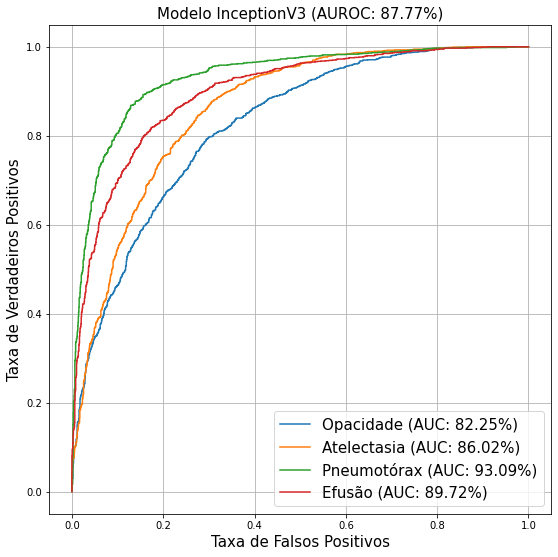

In [40]:
fig, c_ax = plt.subplots(1, 1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label = '{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize = 15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [52]:
bests_thresholds = [32, 32, 44, 72]
for label_index in range(0,4):
  y_pred_bin = binarize_preds(pred_array = y_pred, column = label_index, 
                              threshold = bests_thresholds[label_index])
  matrix = confusion_matrix(test_Y[:, label_index], y_pred_bin)
  acc = (matrix[0,0] + matrix[1,1])/np.sum(matrix)
  precision = matrix[0,0]/(matrix[0,0]+matrix[0,1])
  recall = recall = matrix[0,0]/(matrix[0,0]+matrix[1,0])
  f1_score = (2*precision*recall) / (precision + recall) 
  print(f'=={labels_portugues[label_index]}== \n{matrix},' 
        f' Threshold = {bests_thresholds[label_index]}'
        f'\nAcurácia = {acc*100} % | Precisão = {precision*100} % | '
        f'\nSensibilidade = {recall*100} % | F1 Score = {f1_score*100} %\n')

==Opacidade== 
[[ 984  418]
 [ 311 1199]], Threshold = 32
Acurácia = 74.96565934065934 % | Precisão = 70.18544935805991 % | 
Sensibilidade = 75.98455598455598 % | F1 Score = 72.96996662958843 %

==Atelectasia== 
[[1295  313]
 [ 332  972]], Threshold = 32
Acurácia = 77.85027472527473 % | Precisão = 80.53482587064677 % | 
Sensibilidade = 79.59434542102028 % | F1 Score = 80.06182380216384 %

==Pneumotórax== 
[[1482  220]
 [ 159 1051]], Threshold = 44
Acurácia = 86.98489010989012 % | Precisão = 87.07403055229143 % | 
Sensibilidade = 90.31078610603291 % | F1 Score = 88.66287765480108 %

==Efusão== 
[[1325  243]
 [ 276 1068]], Threshold = 72
Acurácia = 82.1771978021978 % | Precisão = 84.50255102040816 % | 
Sensibilidade = 82.76077451592755 % | F1 Score = 83.62259387819503 %

